In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience


import pims
import trackpy as tp
import av

from scipy.optimize import curve_fit

import time

import os

# Import video

In [2]:
FPS = 60
filepath = "videos/13-11/length_calib.mov"
print(filepath)

print(os.path.splitext(os.path.basename(filepath))[0])

videos/13-11/length_calib.mov
length_calib


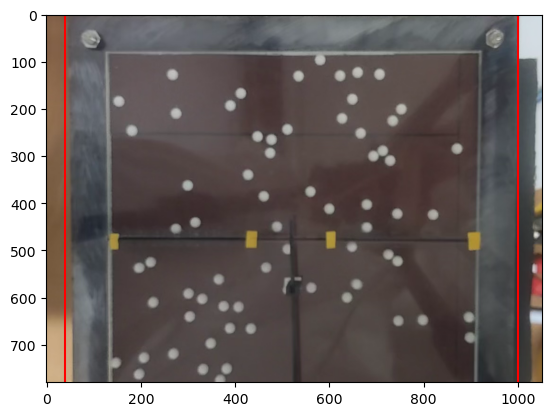

In [ ]:
frames = pims.PyAVReaderTimed(filepath)#pims.as_grey(pims.PyAVReaderTimed(filepath))
plt.imshow(frames[0])

plt.axvline(40, c="r")
plt.axvline(1000, c="r")

# 1000-40

# Tracking Parameters

In [4]:
PARAMS = {
    "diameter": 19,
    "threshold": 10,
    "minmass": 4000
}

# Track one frame

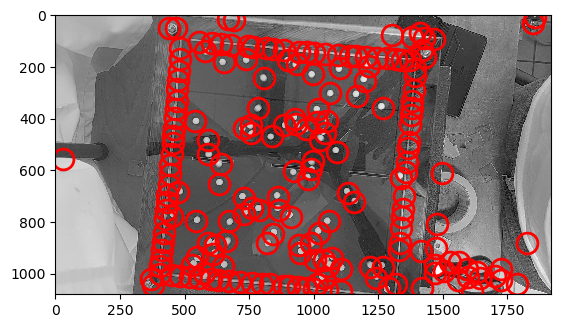

[Text(0.5, 0, 'size'), Text(0, 0.5, 'count')]

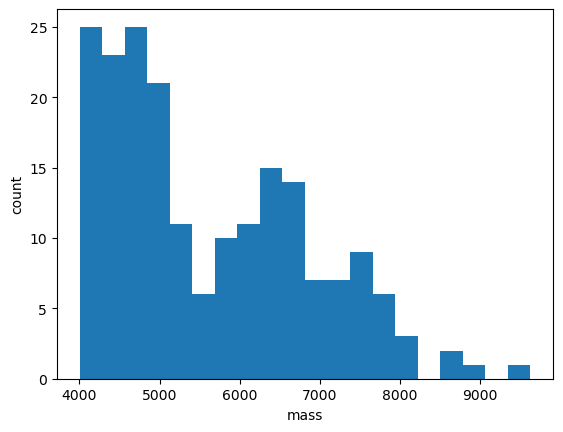

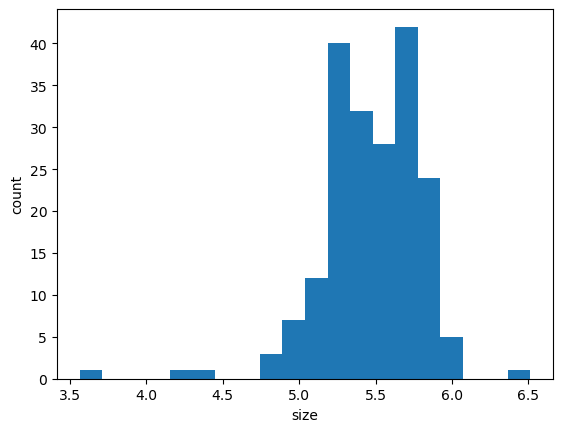

In [5]:
f = tp.locate(frames[0], diameter=PARAMS['diameter'], threshold=PARAMS['threshold'], minmass=PARAMS['minmass'])
tp.annotate(f, frames[0])

# clearly many of these circles are wrong, we look at total brightness ('mass') of these points
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

# clearly many of these circles are wrong, we look at total brightness ('mass') of these points
fig, ax = plt.subplots()
ax.hist(f['size'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='size', ylabel='count')

# Track entire video

In [6]:
tp.quiet()  # Turn off progress reports for best performance
f = tp.batch(frames, diameter=PARAMS['diameter'], threshold=PARAMS['threshold'], minmass=PARAMS['minmass'])

In [7]:
tp.quiet()
t = tp.link(f, 5, memory=3) # this tracks the location of each particle by establishing continuity from frame to frame
#t.head()

t1 = tp.filter_stubs(t, 5)
#t1 = t.copy()
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 118120
After: 13141


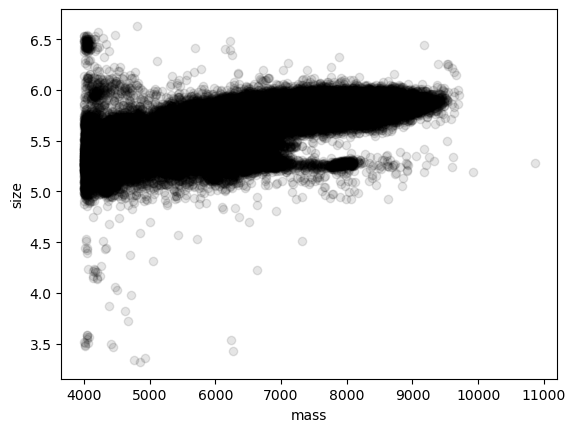

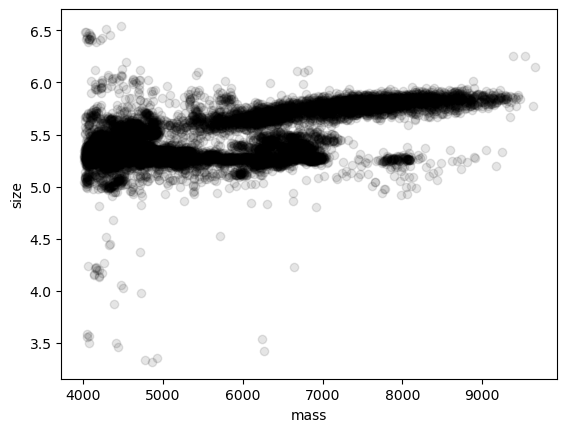

In [8]:
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

# Filter out incorrectly tracked features

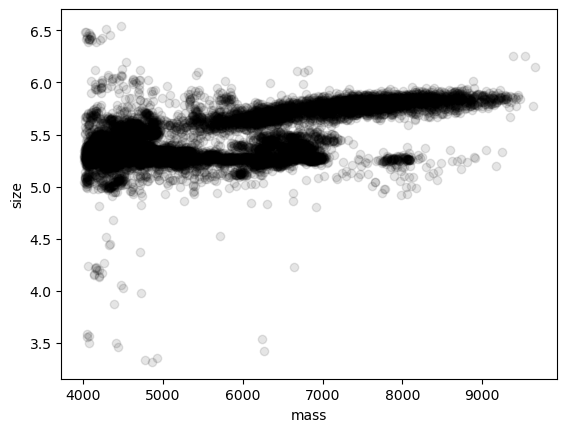

In [9]:
#t2 = t1[((t1['mass'] < 2200) & (t1['size'] > 3.6) & (t1['ecc'] < 0.5))]
t2 = t1
plt.figure()
tp.mass_size(t2.groupby('particle').mean()); # convenience function -- just plots size vs. mass

# Compute mean square displacement

In [10]:
em = tp.emsd(t1, 1., 60) # microns per pixel = 1., frames per second = 60

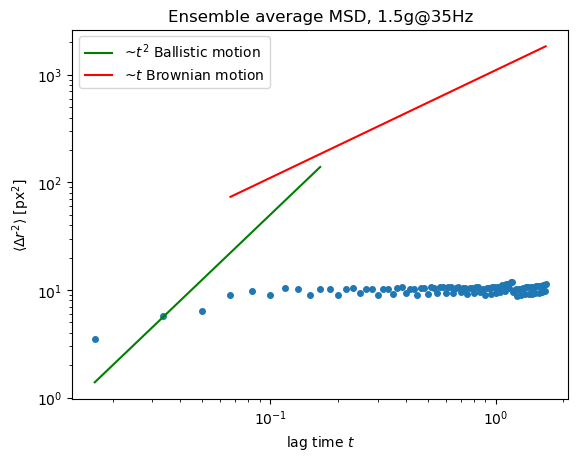

In [11]:
def poly_model(x, alpha, a):
    return a*x**alpha

fig, ax = plt.subplots()
ax.plot(em.index, em, 'o', markersize=4)
ax.plot(em.index[:10], poly_model(em.index[:10], 2, 5000), label=f"~$t^2$ Ballistic motion", c='green') # Ballistic motion at short timescales
ax.plot(em.index[3:], poly_model(em.index[3:], 1, 1.1e3), label=f"~$t$ Brownian motion", c='red') # Brownian motion at long timescales
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [px$^2$]',
       xlabel='lag time $t$')
ax.set_title("Ensemble average MSD, 1.5g@35Hz")
ax.legend()
#plt.savefig("figs/ensemble_MSD_1.5g@35Hz.png", dpi=300)
plt.show()



# Compute particle velocities

In [12]:
tv = t2.copy()
tv.insert(len(tv.columns), 'speed', 0.)
tv.insert(len(tv.columns), 'vx', 0.)
tv.insert(len(tv.columns), 'vy', 0.)

def find_complete_intervals(df, p_num):
    p_frames = df.loc[df['particle']==p_num, 'frame']
    p_intervals = [] # array of tuples containing start and end for each continous interval where particle is detected
    start = True
    first_start = True
    prev, curr = 0, 0
    for i in p_frames: # this actually serves as an index, i.e if p0 is not detected during frame 14, then there is no element 14, only an element 13 then 15
        if first_start: prev = i; first_start = False
        curr = i
        if curr-prev > 1:
            # frame jumping
            #print("frame skip: ",prev, curr)
            start = True

        if start:
            if len(p_intervals) != 0: p_intervals[-1][1] = prev
            p_intervals.append([curr, -69]) # error will occur if -69 not overwritten
        start = False
        prev = curr
    #print(p_intervals)
    if len(p_intervals) != 0: p_intervals[-1][1] = curr
    #else: print("Intervals too short", p_intervals)
    #print(p_intervals)
    return p_intervals

#tv.loc[(tv['particle']==0) & (tv['frame']==3), ['speed']] = 0.9 # assigning a specific frame  

def dist(y1, x1, y2, x2): # compute 2D euclidean norm:
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def compute_speeds(df, p_num, p_intervals) : # compute speeds of single particle over a complete interval
    short_count = 0
    p = df.loc[df['particle']==p_num]
    for i_start, i_end in p_intervals:
        if i_end-i_start == 0: 
            #print(f"Interval length too short: {i_end-i_start=}")
            df.loc[(df['particle']==p_num) & (tv['frame']==i_start), 'speed'] == None
            df.loc[(df['particle']==p_num) & (tv['frame']==i_start), 'vx'] == None
            df.loc[(df['particle']==p_num) & (tv['frame']==i_start), 'vy'] == None
            short_count += 1
            continue
        for i in range(i_start, i_end+1): # i is a frame_index
            if i == i_start: # start of the interval, differentiate over single time_step
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'speed'] = dist(p['y'][i], p['x'][i], p['y'][i+1], p['x'][i+1]) # px/frame
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vx'] =  p.loc[i+1, 'x'] - p.loc[i, 'x'] # px/frame 
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vy'] =  p.loc[i+1, 'y'] - p.loc[i, 'y'] # px/frame 
                #print(p0)
            elif i == i_end: # end of interval
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'speed'] = dist(p['y'][i-1], p['x'][i-1], p['y'][i], p['x'][i])
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vx'] =  p.loc[i, 'x'] - p.loc[i-1, 'x'] # px/frame 
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vy'] =  p.loc[i, 'y'] - p.loc[i-1, 'y'] # px/frame 
            else: # neither start nor beginner, we can average speed over 2 frames for more numerical stability
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'speed'] = dist(p['y'][i-1], p['x'][i-1], p['y'][i+1], p['x'][i+1])/2
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vx'] =  (p.loc[i+1, 'x'] - p.loc[i-1, 'x'])/2 # px/frame 
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vy'] = (p.loc[i+1, 'y'] - p.loc[i-1, 'y'])/2 # px/frame 
    return df, short_count


In [13]:
particle_num = np.max(tv['particle'])

short_count = 0
for i in range(particle_num+1):
    p = tv[tv['particle']==i]
    p_intervals = find_complete_intervals(tv, p_num=i)
    #print(p_intervals)
    tv, sc = compute_speeds(tv, i, p_intervals)
    short_count += sc

print(f"Number of short intervals without well defined velocity {short_count}")

Number of short intervals without well defined velocity 16840


In [14]:
print(f"Particle number: {particle_num}")

Particle number: 117866


# Save data to disk

In [15]:
save_dir = "data/17-11/1.75g"
save_name = os.path.splitext(os.path.basename(filepath))[0]
save_path = os.path.join(save_dir, save_name+".csv")
print(save_path)

data/17-11/1.75g/1.75g@20Hz.csv


In [16]:
tv.to_csv(save_path)

# Plot velocities

In [17]:
def maxwellian(vx, sigma): # for velocity component
    return 1/(np.sqrt(2*np.pi*sigma**2))*np.exp(-vx**2/(2*sigma**2))

In [18]:
v = tv['speed']
v = np.array([e for e in v if not np.isnan(e)])

vx = tv['vx']
vx = np.array([e for e in vx if not np.isnan(e)])

vy = tv['vy']
vy = np.array([e for e in vy if not np.isnan(e)])

print(len(vx))

219736


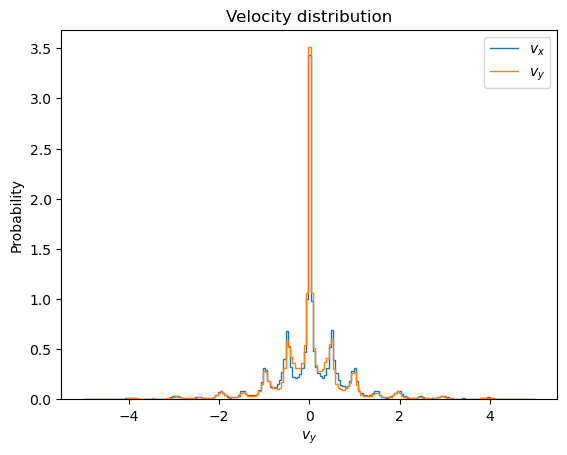

In [19]:
counts_vx, bins = np.histogram(vx, bins=np.linspace(-5, 5, 200), density=True) # normalised
counts_vy, bins2 = np.histogram(vy, bins=np.linspace(-5, 5, 200), density=True) # normalised
plt.stairs(counts_vx, bins, label="$v_x$")
plt.xlabel("$v_x$")
plt.ylabel("Probability")
plt.title("Velocity distribution")
#plt.savefig("figs/funky_distribution.png")

plt.stairs(counts_vy, bins2, label="$v_y$")
plt.xlabel("$v_y$")
plt.ylabel("Probability")

plt.legend()

#plt.savefig("figs/funky_distribution.png")
plt.show()

velocity distribution has this spotty pattern. Which would be normal if we simply didn't have enough data points. However, this does not appear to be the case, 2 reasons are given:
- the spotty distribution is symmetric on both sides, this would not be the case with random noise (basically shot noise)
- there are far more datapoints on this video than on the previous ones we analysed

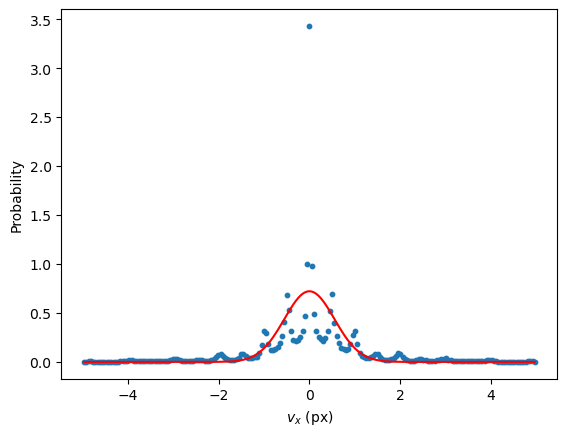

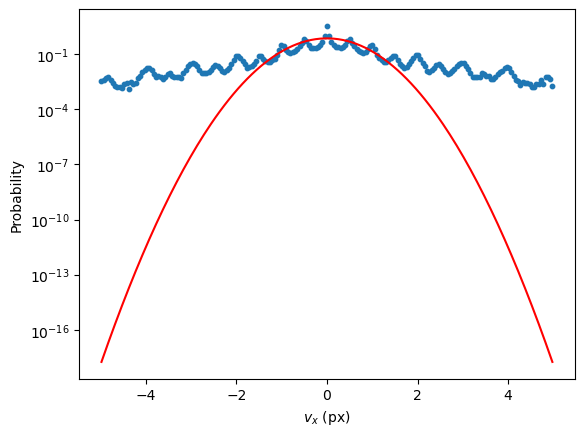

In [20]:

v_space = np.array([(bins[i-1]+bins[i])/2 for i in range(1, len(bins))])

popt, pcov = curve_fit(maxwellian, v_space, counts_vx)

plt.plot(v_space, maxwellian(v_space, popt[0]), c='r')
plt.scatter(v_space, counts_vx, s=10)
plt.xlabel("$v_x$ (px)")
plt.ylabel("Probability")
#plt.title("$v_x$ distribution (lin)")
#plt.savefig("figs/v_lin.png", dpi=300)
plt.show()

plt.plot(v_space, maxwellian(v_space, popt[0]), c='r')
plt.scatter(v_space, counts_vx, s=10)
plt.xlabel("$v_x$ (px)")
plt.ylabel("Probability")
plt.yscale('log')
#plt.title("$v_x$ distribution (log)")
#plt.savefig("figs/v_log.png", dpi=300)
plt.show()

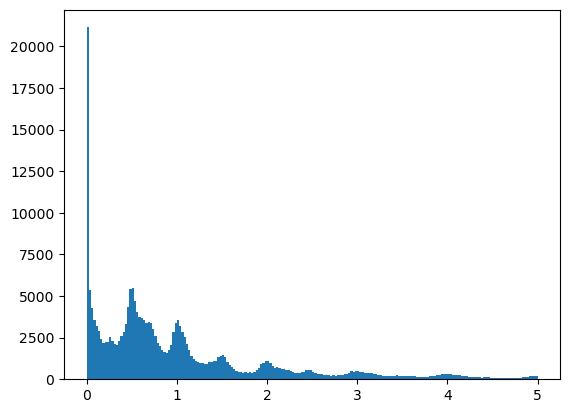

In [21]:
plt.hist(v, 200)
plt.show()